# Анализ оттока клиентов банка

Маркетинговому отделу банка «Метанпром» необходима помощь в определении зон, требующих применения характерной стратегии, относительно клиентов: стратегия на удержание клиента, стратегия для повышения ltv, количества потребляемых продуктов банка и другие.

## Введение

**Проект направлен** на выявление зон-признаков клиентов, склонных к прекращению сотрудничества с банком, и дальнейшую разработку рекомендаций по благоприятному воздействию на представителей каждой конкретной обозначенной зоны. 

**Задачи исследования**:

* Провести исследовательский анализ данных (EDA) для выявления общих закономерностей и проблемных зон;
* Проверить статистические гипотезы о влиянии заранее выявленных ключевых факторов на отток;
* Провести сегментацию пользователей на основе стратегических показателей;
* Сформулировать рекомендации по работе с выделенными сегментами.

**Описание исходных данных:**

Данные о клиентах банка «Метанпром» содержатся в /datasets/bank_scrooge.csv.

Структура bank_scrooge.csv:

* *USERID* — идентификатор пользователя;
* *score* — баллы кредитного скоринга;
* *city* — город;
* *gender* — пол;
* *age* — возраст;
* *equity* — количество баллов собственности;
* *balance* — баланс на счёте;
* *products* — количество продуктов, которыми пользуется клиент;
* *credit_card* — есть ли кредитная карта;
* *last_activity* — наличие активности за последние 3 месяца;
* *EST_SALARY* — оценочный доход клиента;
* *сhurn* — признак оттока/наличие желания прекратить сотрудничество с банком.

**Исследование пройдет в 5 основных этапов:**

 * Обзор исходных данных;
 * Предобработка исходных данных;
 * Исследовательский анализ;
 * Проверка гипотез;
 * Сегментация клиентов банка.

<a id='Содержание'></a>
## Содержание

1. [Обзор исходных данных](#Обзор-исходных-данных)
2. [Предобработка данных](#Предобработка-данных)
3. [Исследовательский анализ данных](#Исследовательский-анализ-данных)
    * [Формирование портретов клиентов, склонных к прекращению сотрудничества и лояльных, и их сравнение](#Портреты-клиентов)
    * [Анализ распределения непрерывных показателей, включая отдельный анализ по разрезу клиентов, склонных к оттоку](#Анализ-непрерывного-распределения)
    * [Анализ распределения по категориям/категориальным значениям](#Анализ-категориального-распределения)
    * [Корреляционный анализ](#Корреляционный-анализ)
4. [Проверка статистических гипотез](#Проверка-статистических-гипотез)
    * [Доход клиентов значимо отличается у лояльных клиентов и склонных к прекращению сотрудничества](#Гипотеза-1)
    * [Клиенты, пользующиеся 1 продуктом, младше клиентов, использующих 2 и более продуктов банка](#Гипотеза-2)
5. [Сегментация пользователей](#Сегментация-пользователей)
    * [Разделение клиентов по высокоотточным признакам](#Разделение-клиентов)
    * [Приоритизация сегментов](#Приоритизация-сегментов)
6. [Общий вывод](#Общий-вывод)
7. [Презентация](#Презентация)

<a id='Обзор-исходных-данных'></a>
## 1 Обзор исходных данных

In [1]:
%%capture
!pip install missingno
!pip install phik

#импортируем необходимые для проекта библиотеки
#основные либы для исследования и визуализации
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

#для кодирования признаков, выделения взаимосвязей между ними и комплексного заполнения пропусков
import phik
from phik.report import plot_correlation_matrix #для выявления взаимосвязей между признаками
from sklearn.preprocessing import StandardScaler #для нормализации числовых и закодированных признаков по отклонению от среднего
from sklearn.experimental import enable_iterative_imputer #для заполнения пропусков
from sklearn.impute import IterativeImputer

#для проверки гипотез
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

#отключим неинформативные предупреждения для выполняемых блоков тетрадки
import warnings
warnings.filterwarnings("ignore")

In [2]:
#объявим переменную с дф датасета 
customers_info = pd.read_csv('/datasets/bank_scrooge.csv')

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


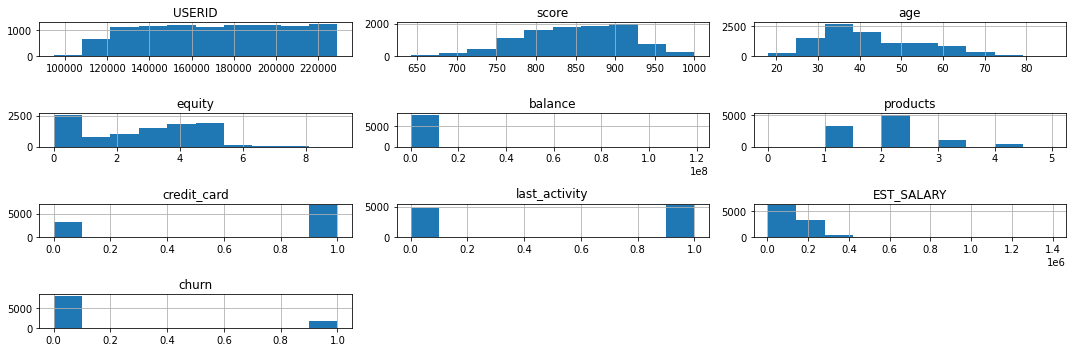

In [3]:
#выведем информацию по дф 
display(customers_info.head())
customers_info.info()
customers_info.hist(figsize=(15, 5))
plt.tight_layout()
plt.show()

Видим, что в наших данных имеются пропуски в столбцах *age* и *balance*, аномально высокие значения в *balance* и *EST_SALARY* (тут также есть аномально низкие значения, однако столбец представляет собой справочные данные, поэтому вмешательство не требуется), а также нулевые значения в *products* (согласно документации в наших данных только клиенты с 1 и более продуктами), кроме этого есть необходимость приведения названий столбцов к нижнему регистру и смены типа данных столбца *age* с float на int.

Смена на целочисленный тип может понадобиться и в столбце *score*, проверим, есть ли там дробные значения:

In [4]:
#логически индексируем дробные значения в столбце, затем выводим True, если есть хотя бы одно True (хотя бы одно дробное)
(customers_info['score'] % 1 != 0).any()

False

Дробных значений в столбце нет, значит так же сменим тип на int. 

Детальнее взглянем на пропуски:

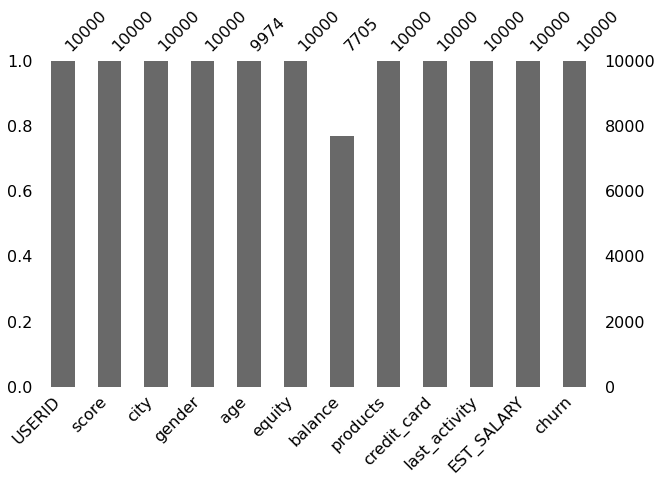

In [5]:
#визуализируем пропуски относительно всех данных

msno.bar(customers_info, figsize=(10, 6))
plt.show()

In [6]:
#Выведем абсолютное количество и долю пропусков таблицей
pd.DataFrame({
    'Missing Count': customers_info[['balance', 'age']].isnull().sum(),
    'Part, %': customers_info[['balance', 'age']].isnull().mean() * 100})

,Missing Count,"Part, %"
balance,2295,22.95
age,26,0.26


Попытаемся больше узнать о природе пропусков и определим их тип для дальнейшей обработки:

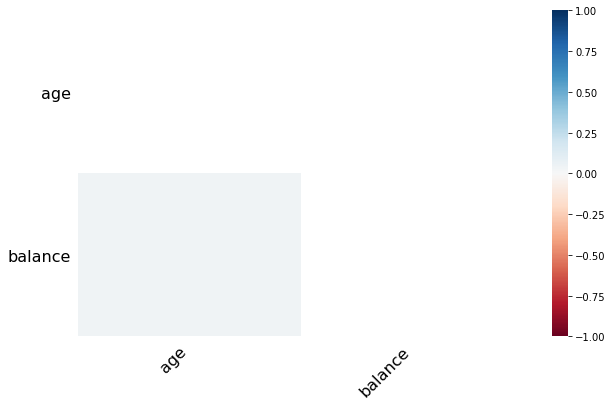

In [7]:
msno.heatmap(customers_info, figsize=(10, 6))
plt.show()

Между собой пропуски предварительно никак не связаны.
Поищем связь с другими столбцами датафрейма:

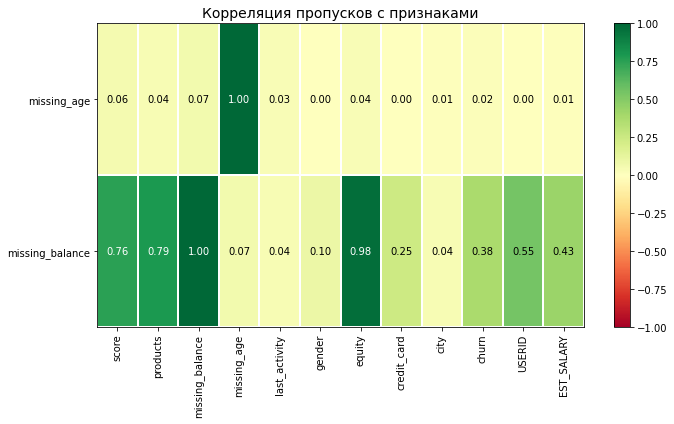

In [8]:
#считать корреляцию будем с помощью phi_k, т.к. это универсальный способ выявить взаимосвязь с разными типами значений,
#который, к тому же, учитывает не только прямую корреляцию

#создадим индикаторы пропусков, чтобы считать только их корреляцию 
customers_info['missing_balance'] = customers_info['balance'].isna().astype(int)
customers_info['missing_age'] = customers_info['age'].isna().astype(int)

#формирование матрицы ФИк с указанием числовых столбцов 
phik_missing_matrix = (customers_info[customers_info.columns.difference(['balance', 'age'])]
                       .phik_matrix(interval_cols=['score', 'EST_SALARY'])
                       .loc[['missing_balance', 'missing_age'], customers_info.columns.difference(['balance', 'age'])])

#визуализация с преобразованием матрицы в массив на входе, метки берем с оригинальной матрицы
plot_correlation_matrix(phik_missing_matrix.to_numpy(), 
                        x_labels=phik_missing_matrix.columns.to_list(), 
                        y_labels=phik_missing_matrix.index.to_list(),
                        title='Корреляция пропусков с признаками',
                        figsize=(10, 6))

Таким образом, пропуски в графе "возраст" относятся к группе MCAR и не оказывают влияние на другие показатели и немногочислены - их можно заполнить значениями центральной тенденции без потери качества данных. 

Сложнее с пропусками в графе "баланс" группы MNAR, так как это многочисленная группа значений, которая взаимосвязана с другими данными, необходимо будет использовать более комплексный подход к их заполнению. 

Проверим уникальные категориальные значения в датафрейме:

In [9]:
for i in ['equity', 'city', 'gender', 'products', 'credit_card', 'last_activity', 'churn']:
    display(i, customers_info[i].unique())

'equity'

array([1, 5, 0, 4, 3, 2, 6, 7, 8, 9])

'city'

array(['Рыбинск', 'Ярославль', 'Ростов'], dtype=object)

'gender'

array(['Ж', 'М'], dtype=object)

'products'

array([2, 3, 1, 4, 5, 0])

'credit_card'

array([0, 1])

'last_activity'

array([1, 0])

'churn'

array([1, 0])

Уникальные категориальные значения в норме.

Проверим данные на дубликаты:

In [10]:
customers_info.duplicated(keep=False).sum()

0

Полных дубликатов нет, посмотрим на дубликаты в *USERID*:

In [11]:
customers_info[customers_info.duplicated(subset='USERID', keep=False)].sort_values(by='USERID')

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn,missing_balance,missing_age
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1,0,0
7694,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0,1,0
7542,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0,1,0
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1,0,0
5896,120258,905.0,Ярославль,М,30.0,0,NaN,1,1,1,146427.96,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2597,226719,990.0,Ярославль,М,37.0,4,14648692.14,2,0,0,934412.61,1,0,0
8205,227795,840.0,Рыбинск,М,34.0,2,350768.03,1,1,0,102036.14,1,0,0
8497,227795,839.0,Ярославль,М,34.0,2,326593.14,2,1,0,103314.92,0,0,0
6457,228075,839.0,Рыбинск,М,39.0,5,507199.85,3,0,1,85195.80,0,0,0


Найдено 146 дубликатов по *USERID*.

**Вывод:**

Мы провели первичный обзор данных, наблюдения для дальнейшей обработки:

* Имеются пропуски в столбцах *age* (26, 0.26%), которые относятся к группе MCAR и не имеют сильной корреляции с другими показателями - необходимо заполнение центральной тенденцией по столбцу, и *balance* (2295, 22.95%), которые относятся к группе MNAR, многочисленны и имеют взаимосвязь с другими показателями - необходимо комплексное заполнение пропусков;

* Присутствуют аномально высокие значения в *balance* (выбивающиеся высокие значения в столбце с банковским балансом - нормальное явление) и *EST_SALARY* (тут также есть аномально низкие значения, однако столбец представляет собой справочные данные, поэтому вмешательство не требуется);

* Есть нулевые значения в *products* (согласно документации в наших данных только клиенты с 1 и более продуктами), строки с подобными клиентами должны быть удалены из наших данных;

* Необходимо привести названия столбцов к нижнему регистру и сменить тип данных столбцов *age* и *score* с float на int;

* Найдено 146 дубликатов в *USERID*.

[Вернуться к содержанию](#Содержание)

<a id='Предобработка-данных'></a>
## 2 Предобработка данных

Приведем наименования столбцов к нижнему регистру:

In [12]:
#приводим к нижнем регистру
customers_info.columns = customers_info.columns.str.lower()
#скорректируем название первого столбца
customers_info.rename(columns={'userid': 'user_id'}, inplace=True)

Ранее мы выявили строки клиентов с 0 количеством продуктов, посмотрим детальнее:

In [13]:
customers_info[customers_info['products'] == 0]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missing_balance,missing_age
8957,147837,962.0,Рыбинск,Ж,79.0,3,NaN,0,0,0,25063.96,1,1,0


Найден 1 человек с 0 продуктов, удалим его из нашего датафрейма (рассматриваем только действующих клиентов банка):

In [14]:
customers_info = customers_info[customers_info['products'] != 0]

Обработаем пропуски в столбце *age*, послкольку распределение значений столбца имеет хвост вправо (смещенный центр), используем для заполнения медиану: 

In [15]:
customers_info['age'] = customers_info['age'].fillna(customers_info['age'].median())

Сменим тип данных столбцов age и score с float на int:

In [16]:
customers_info[['age', 'score']] = customers_info[['age', 'score']].astype(int)

Ранее мы нашли 146 дубликатов по *user_id*, полных дубликатов нет, также при обзоре id дубликатов данные по ним различаются во всем - возможна техническая ошибка при логировании. Присвоим дубликатам новые id в рамках нашего исследования:

In [17]:
#проверим, есть ли значения более 1М в столбце 
customers_info[customers_info['user_id'] >= 1000000]['user_id'].count()

0

In [18]:
#присвоим дубликатам новое значение, которое начинается с миллиона
customers_info.loc[customers_info.duplicated(subset='user_id', keep='last'), 'user_id'] += 1000000
#проверим остались ли дубликаты
display(customers_info[customers_info.duplicated(subset='user_id', keep=False)].sort_values(by='user_id'))
print('-'*30)
#также проверим исправность присвоения новых значений
print('Всего новых id:', customers_info[customers_info['user_id'] >= 1000000]['user_id'].count())
customers_info[customers_info['user_id'] >= 1000000].sample(3)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missing_balance,missing_age


------------------------------
Всего новых id: 73


,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missing_balance,missing_age
1247,1228075,932,Ярославль,М,40,5,7601719.20,2,1,1,408121.16,0,0,1
1389,1221156,687,Рыбинск,М,61,0,NaN,1,1,1,136361.72,0,1,0
1740,1220816,840,Ярославль,Ж,41,3,1193287.13,2,1,1,76434.94,1,0,0


Ранее мы заполнили пропуски в *age*, теперь перейдем к более сложному заполнению пропусков в *balance*, для этого будем использовать множественную импутацию, однако сначала закодируем нечисловые категориальные значения.

Изменим значения "М" и "Ж" на 1 и 0 соответственно в *gender*, а значения *city* закодируем с помощью отдельных столбцов с фиктивными бинарными переменными:

In [19]:
#кодируем значения пола
customers_info['gender'] = customers_info['gender'].map({'М': 1, 'Ж': 0})

#кодируем значения города, создавая отдельные столбцы для каждого города с бинарными значениями
#создаем доп столбцы с кодированными значениями на срезе по городам
city_encoded = pd.get_dummies(customers_info['city'], prefix='city') 
#объединяем полученные доп столбцы с основным дф, чтобы остался столбец city
customers_info = pd.concat([customers_info, city_encoded], axis=1)

#проверяем
customers_info.sample(3)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missing_balance,missing_age,city_Ростов,city_Рыбинск,city_Ярославль
8282,165320,853,Рыбинск,0,56,1,334630.55,2,1,1,90653.06,0,0,0,0,1,0
5624,152399,839,Рыбинск,1,42,5,668731.52,2,1,1,182790.53,1,0,0,0,1,0
7142,210784,784,Ярославль,1,28,4,690120.16,3,0,1,105686.11,1,0,0,0,0,1


Теперь перейдем к заполнению пропусков в *balance*:

In [20]:
#для проверки изменений
customers_info['balance'].describe()

count    7.705000e+03
mean     8.277943e+05
std      1.980614e+06
min      0.000000e+00
25%      2.955542e+05
50%      5.242722e+05
75%      9.807058e+05
max      1.191136e+08
Name: balance, dtype: float64

In [21]:
#сначала проведем нормализацию данных, тк у нас значения с разным отклонением в разных столбцах

#выделим столбцы с непрерывными значениями для нормализации
continuous_cols = ['balance', 'score']

#будем заполнять и нормализировать на копии наших данных с взаимосвязанными столбцами
customers_scaled = customers_info[['score', 'products', 'missing_balance', 'equity', 'balance']].copy()

#нормализация значений с большим масштабом
scaler = StandardScaler()
customers_scaled[continuous_cols] = scaler.fit_transform(customers_info[continuous_cols])

#итеративная импутация
imputer = IterativeImputer(min_value=0)
customers_imputed = imputer.fit_transform(customers_scaled)

#переводим данные в дф
customers_scaled = pd.DataFrame(customers_imputed, columns=customers_scaled.columns, index=customers_info.index)

#конвертируем нормализованные данные обратно 
customers_scaled[continuous_cols] = scaler.inverse_transform(customers_scaled[continuous_cols])

#проверим изменения
customers_scaled['balance'].describe()

count    9.999000e+03
mean     8.404327e+05
std      1.739433e+06
min      0.000000e+00
25%      3.572034e+05
50%      7.492564e+05
75%      9.401228e+05
max      1.191136e+08
Name: balance, dtype: float64

In [22]:
#перенесем данные в основной фрейм
customers_info['balance'] = customers_scaled['balance']

Проверим текущие изменения:

In [23]:
customers_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          9999 non-null   int64  
 1   score            9999 non-null   int64  
 2   city             9999 non-null   object 
 3   gender           9999 non-null   int64  
 4   age              9999 non-null   int64  
 5   equity           9999 non-null   int64  
 6   balance          9999 non-null   float64
 7   products         9999 non-null   int64  
 8   credit_card      9999 non-null   int64  
 9   last_activity    9999 non-null   int64  
 10  est_salary       9999 non-null   float64
 11  churn            9999 non-null   int64  
 12  missing_balance  9999 non-null   int64  
 13  missing_age      9999 non-null   int64  
 14  city_Ростов      9999 non-null   uint8  
 15  city_Рыбинск     9999 non-null   uint8  
 16  city_Ярославль   9999 non-null   uint8  
dtypes: float64(2),

Исправления применены корректно. 

**Вывод:**

Проведена предобработка исходных данных:

* Наименования столбцов приведены к нижнему регистру;
* Удалена строка с 0 продуктов;
* Данные проверены на дубликаты, созданы уникальные id на основе дублированных (строки различны);
* Категориальные данные типа object кодированы бинарными числовыми значениями;
* Заполнены пропуски: *age* - медианное значение по столбцу, *balance* - итерационное импутирование по взаимосвязанным столбцам с предварительной нормализацией непрерывных значений.

[Вернуться к содержанию](#Содержание)

<a id='Исследовательский-анализ-данных'></a>
## 3 Исследовательский анализ данных

<a id='Портреты-клиентов'></a>
Сформируем портреты клиентов, склонных к прекращению сотрудничества и лояльных, и сравним их:

In [24]:
#заранее разделим данные на 2 группы отточных и не отточных клиентов, чтобы не делать этого в следующем коде таблицы
churn_0 = customers_info[customers_info['churn'] == 0]
churn_1 = customers_info[customers_info['churn'] == 1]

#аналогично со столбцами, выделим их в отдельные группы для разного использования центральной тенденции
continuous_cols = ['balance', 'est_salary']
discrete_cols = ['age', 'equity', 'products', 'score']
categorical_cols = ['city', 'gender', 'credit_card', 'last_activity']

#переменная для сбора массива данных будущей таблицы
results = []

#обработка столбцов с непрерывными значениями
for col in continuous_cols:
    mean_0, mean_1 = churn_0[col].mean().round(1), churn_1[col].mean().round(1)
    median_0, median_1 = churn_0[col].median().round(1), churn_1[col].median().round(1)
    relative_diff = round(((mean_1 - mean_0) / mean_0) * 100, 2)

    results.append([col, 'mean', mean_0, relative_diff, mean_1])
    results.append([col, 'median', median_0, None, median_1])

#обработка столбцов с дискретными значениями
for col in discrete_cols:
    median_0, median_1 = churn_0[col].median().round(1), churn_1[col].median().round(1)
    results.append([col, 'median', median_0, None, median_1])

#обработка столбцов с категориальными значениями
for col in categorical_cols:
    mode_0 = churn_0[col].mode()[0]
    mode_1 = churn_1[col].mode()[0]
    results.append([col, 'mode', mode_0, None, mode_1])

#создаем таблицу
customers_portrait = pd\
.DataFrame(results, columns=['feature', 'central_tendency', 'churn_0', 'relative_difference_%', 'churn_1'])

#редактируем вывод категориальных значений с числовых в текстовые
customers_portrait.loc[customers_portrait['feature'] == 'gender', ['churn_0', 'churn_1']] = customers_portrait\
.loc[customers_portrait['feature'] == 'gender', ['churn_0', 'churn_1']].replace({0: 'Ж', 1: 'М'})

customers_portrait.loc[(customers_portrait['feature'] == 'credit_card') | (customers_portrait['feature'] == 'last_activity')\
                       , ['churn_0', 'churn_1']] = customers_portrait.loc[(customers_portrait['feature'] == 'credit_card')\
                    | (customers_portrait['feature'] == 'last_activity'), ['churn_0', 'churn_1']].replace({0: 'Нет', 1: 'Есть'})


customers_portrait

,feature,central_tendency,churn_0,relative_difference_%,churn_1
0,balance,mean,775364.3,46.13,1133043.8
1,balance,median,735863.9,NaN,789300.2
2,est_salary,mean,147783.2,0.36,148310.7
3,est_salary,median,118257.7,NaN,125395.2
4,age,median,40.0,NaN,39.0
5,equity,median,3.0,NaN,4.0
6,products,median,2.0,NaN,2.0
7,score,median,848.0,NaN,866.0
8,city,mode,Ярославль,NaN,Ярославль
9,gender,mode,Ж,NaN,М


Таким образом по таблице 

Портрет лояльного клиента (*churn_0*):

* Баланс (медиана *balance*): 735863.9;
* Примерный уровень дохода (медиана *est_salary*): 118257.7;
* Возраст (медиана *age*): 40;
* Количество баллов собственности (медиана *equity*): 2;
* Количество пользуемых продуктов банка (медиана *products*): 2;
* Количество баллов кредитного скоринга (медиана *score*): 848;
* Город (мода *city*): Ярославль;
* Пол (мода *gender*): Ж;
* Наличие кредитной карты (мода *credit_card*): Есть;
* Наличие активности/взаимодействия с банковскими сервисами за последние 3 месяца (мода *last_activity*): Нет.

Портрет отточного клиента (*churn_1*):

* Баланс (медиана *balance*): 789300.2;
* Примерный уровень дохода (медиана *est_salary*): 125395.2;
* Возраст (медиана *age*): 39;
* Количество баллов собственности (медиана *equity*): 4;
* Количество пользуемых продуктов банка (медиана *products*): 2;
* Количество баллов кредитного скоринга (медиана *score*): 866;
* Город (мода *city*): Ярославль;
* Пол (мода *gender*): М;
* Наличие кредитной карты (мода *credit_card*): Есть;
* Наличие активности/взаимодействия с банковскими сервисами за последние 3 месяца (мода *last_activity*): Есть.

Характерные различия между двумя типичными клиентами:

* Баланс отточного клиента выше на 357679.5 (46%);
* Минимальная разница в примерном уровне дохода, у отточного клиента выше на 7137.5 (6%);
* Минимальная разница в возрасте, отточный клиент моложе на 1 год (3%);
* У отточного клиента больше баллов собственности на 2 (100%);
* У отточного клиента больше баллов скоринга на 18 (2%);
* Совпадает город: Ярославль;
* Пол лояльного клиента: Ж, отточного клиента: М;
* У обоих клиентов есть кредитная карта;
* У отточного клиента есть активность за последние 3 месяца, у лояльного - нет. 

<a id='Анализ-непрерывного-распределения'></a>
Проведем анализ распределения непрерывных показателей, включая отдельный анализ по разрезу клиентов, склонных к оттоку:

Также для дальнейших расчетов и визуализаций определим средний уровень оттока по банку:

In [25]:
churn_part = customers_info['churn'].mean()
print(f'Доля оттока среди клиентов банка: {churn_part:.1%}')

Доля оттока среди клиентов банка: 18.2%


<a id=''></a>
Выделим необходимые показатели, также добавим дискретные показатели с большим количеством значений:

*balance*, *est_salary*, *age*, *score*.

*balance*:

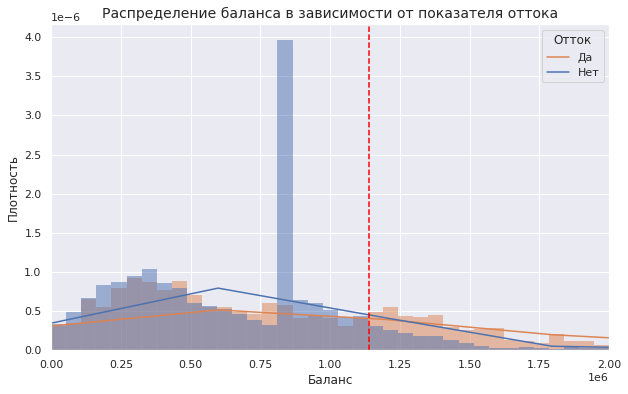

In [26]:
#установим фон для графиков
sns.set_theme(style="darkgrid")
#задаем размер полотна
plt.figure(figsize=(10, 6))
#строим гистограмму, т.к. имеем дело с непрерываными/дискретными значениями с большим размахом
sns.histplot(data=customers_info, x='balance', hue='churn', stat="density", common_norm=False, kde=True, alpha=0.5)
#ограничим значения по X для лучшей читаемости 
plt.xlim(0, 2000000)
#добавим вертикальную линию, которая показывает границу, с которой начинается отток по показателю
plt.axvline(x=1140000, color='red', linestyle='--')
#добавляем подписи
plt.title("Распределение баланса в зависимости от показателя оттока", fontsize=14)
plt.xlabel("Баланс", fontsize=12)
plt.ylabel("Плотность", fontsize=12)
plt.legend(title='Отток', labels=['Да', 'Нет'])
plt.show()

Согласно гистограмме отток клиентов по показателю *balance* начинается при его значении >1140000.

In [27]:
print('Доля оттока по выделенному сегменту составляет',\
      round(customers_info[customers_info['balance']>1140000]['churn'].mean()*100, 1), '%')

Доля оттока по выделенному сегменту составляет 39.8 %


*est_salary*:

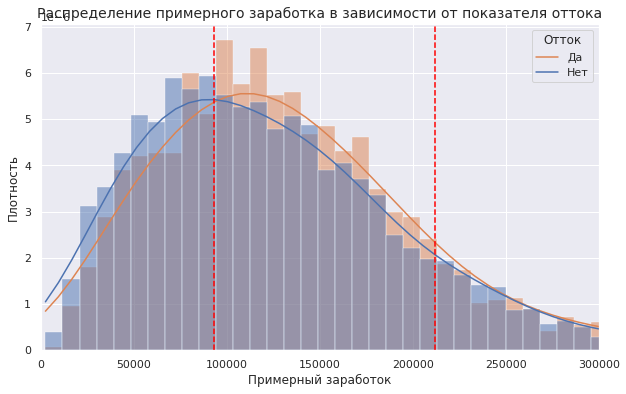

In [28]:
#задаем размер полотна
plt.figure(figsize=(10, 6))
#строим гистограмму, т.к. имеем дело с непрерываными/дискретными значениями с большим размахом
sns.histplot(data=customers_info, x='est_salary', hue='churn', stat="density", common_norm=False, kde=True, alpha=0.5)
#ограничим значения по X для лучшей читаемости 
plt.xlim(0, 300000)
#добавим вертикальную линию, которая показывает границу, с которой начинается отток по показателю
plt.axvline(x=93000, color='red', linestyle='--')
plt.axvline(x=212000, color='red', linestyle='--')
#добавляем подписи
plt.title("Распределение примерного заработка в зависимости от показателя оттока", fontsize=14)
plt.xlabel("Примерный заработок", fontsize=12)
plt.ylabel("Плотность", fontsize=12)
plt.legend(title='Отток', labels=['Да', 'Нет'])
plt.show()

Согласно гистограмме отток клиентов по показателю *est_salary* находится в рамках его значения от 93000 до 212000. 

In [29]:
print('Доля оттока по выделенному сегменту составляет',\
      round(customers_info[(customers_info['est_salary']>93000) & (customers_info['est_salary']<212000)]['churn']\
            .mean()*100, 1), '%')

Доля оттока по выделенному сегменту составляет 20.2 %


*age*:

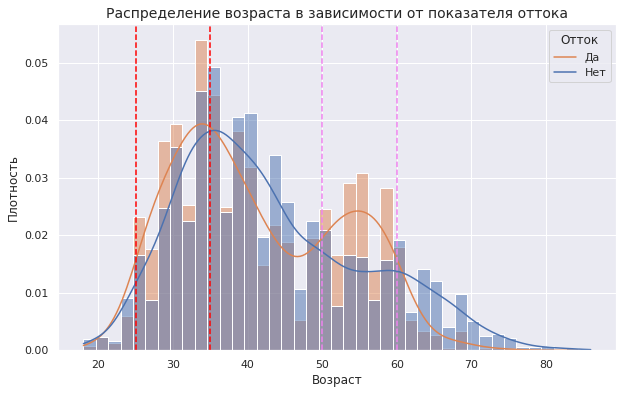

In [30]:
#задаем размер полотна
plt.figure(figsize=(10, 6))
#строим гистограмму, т.к. имеем дело с непрерываными/дискретными значениями с большим размахом
sns.histplot(data=customers_info, x='age', hue='churn', stat="density", common_norm=False, kde=True, alpha=0.5)
#добавим вертикальную линию, которая показывает границу, с которой начинается отток по показателю
plt.axvline(x=25, color='red', linestyle='--')
plt.axvline(x=35, color='red', linestyle='--')
plt.axvline(x=50, color='violet', linestyle='--')
plt.axvline(x=60, color='violet', linestyle='--')
#добавляем подписи
plt.title("Распределение возраста в зависимости от показателя оттока", fontsize=14)
plt.xlabel("Возраст", fontsize=12)
plt.ylabel("Плотность", fontsize=12)
plt.legend(title='Отток', labels=['Да', 'Нет'])
plt.show()

Согласно гистограмме отток клиентов по показателю *age* находится в рамках его значения на отрезках от 25 до 35 и от 50 до 60.

In [31]:
print('Доля оттока по выделенным сегментам составляет',\
      round(customers_info[((customers_info['age']>25) & (customers_info['age']<35)) |\
                           ((customers_info['age']>50) & (customers_info['age']<60))]['churn']\
                           .mean()*100, 1), '%')

Доля оттока по выделенным сегментам составляет 24.3 %


*score*:

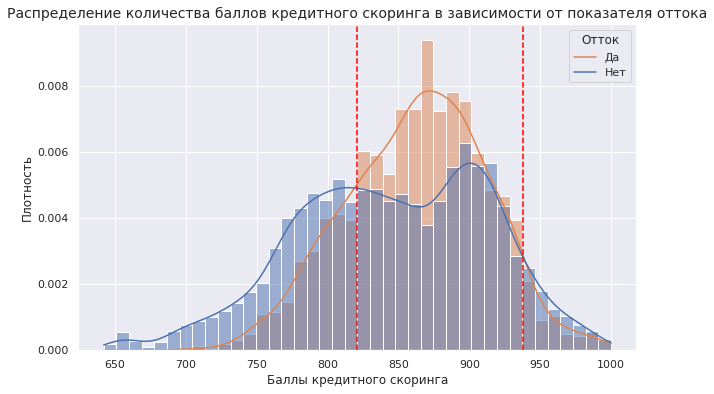

In [32]:
#задаем размер полотна
plt.figure(figsize=(10, 6))
#строим гистограмму, т.к. имеем дело с непрерываными/дискретными значениями с большим размахом
sns.histplot(data=customers_info, x='score', hue='churn', stat="density", common_norm=False, kde=True, alpha=0.5)
#добавим вертикальную линию, которая показывает границу, с которой начинается отток по показателю
plt.axvline(x=821, color='red', linestyle='--')
plt.axvline(x=938, color='red', linestyle='--')
plt.title("Распределение количества баллов кредитного скоринга в зависимости от показателя оттока", fontsize=14)
plt.xlabel("Баллы кредитного скоринга", fontsize=12)
plt.ylabel("Плотность", fontsize=12)
plt.legend(title='Отток', labels=['Да', 'Нет'])
plt.show()

Согласно гистограмме отток клиентов по показателю *score* находится в рамках его значения от 821 до 938.

In [33]:
print('Доля оттока по выделенному сегменту составляет',\
      round(customers_info[(customers_info['score']>821) & (customers_info['score']<938)]['churn']\
            .mean()*100, 1), '%')

Доля оттока по выделенному сегменту составляет 23.0 %


<a id='Анализ-категориального-распределения'></a>
Проведем анализ распределения категориальных показателей, включая отдельный анализ по разрезу клиентов, склонных к оттоку:

*city*,	*gender*, *equity*, *products*, *credit_card*, *last_activity*.

*city*:

In [34]:
#сначала составим таблицу по признаку
customers_col_pivot = customers_info.pivot_table(index='city', values='churn', aggfunc=['mean', 'sum', 'count']).reset_index()
customers_col_pivot.columns = ['city', 'churn_part_%', 'users_count_churn', 'users_count_total']
customers_col_pivot['churn_part_%'] = round(customers_col_pivot['churn_part_%']*100, 1)
customers_col_pivot = customers_col_pivot.sort_values(by='churn_part_%', ascending=False)
customers_col_pivot

,city,churn_part_%,users_count_churn,users_count_total
2,Ярославль,19.0,1117,5888
0,Ростов,18.8,266,1417
1,Рыбинск,16.2,436,2694


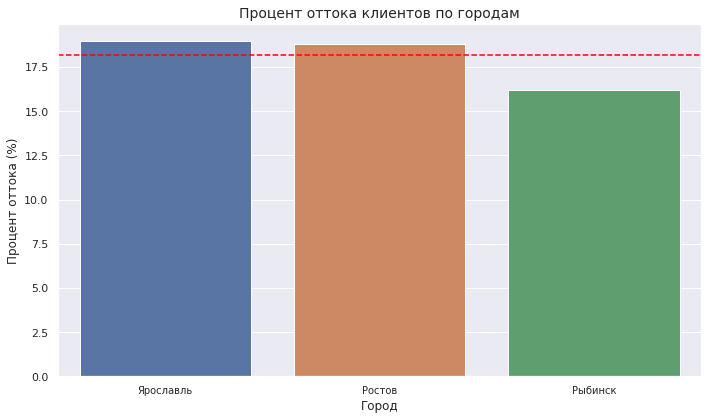

In [35]:
#строим график
plt.figure(figsize=(10, 6))
sns.barplot(data=customers_col_pivot, x='city', y='churn_part_%')
plt.title('Процент оттока клиентов по городам', fontsize=14)
plt.xlabel('Город', fontsize=12)
plt.ylabel('Процент оттока (%)', fontsize=12)
plt.axhline(y=18.2, color='red', linestyle='--')
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show()

Менее лояльными являются клиенты из Ростова (18.8% доля оттока) и Ярославля (19%).

*gender*:

In [36]:
#сначала составим таблицу по признаку
customers_col_pivot = customers_info.pivot_table(index='gender', values='churn', aggfunc=['mean', 'sum', 'count']).reset_index()
customers_col_pivot.columns = ['gender', 'churn_part_%', 'users_count_churn', 'users_count_total']
customers_col_pivot['churn_part_%'] = round(customers_col_pivot['churn_part_%']*100, 1)
customers_col_pivot = customers_col_pivot.sort_values(by='churn_part_%', ascending=False).replace({0: 'Ж', 1: 'М'})
customers_col_pivot

,gender,churn_part_%,users_count_churn,users_count_total
1,М,23.6,1183,5005
0,Ж,12.7,636,4994


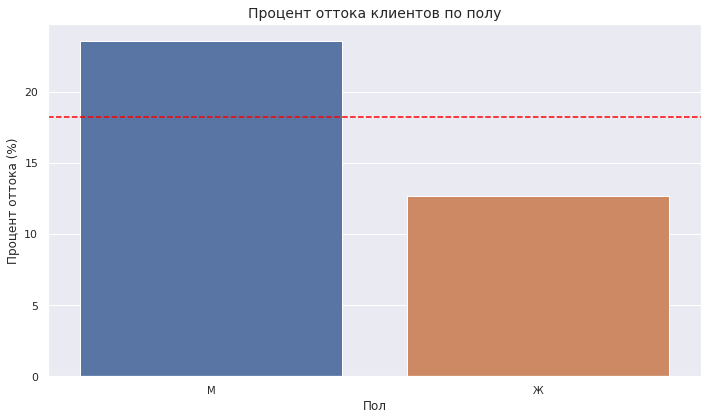

In [37]:
#строим график
plt.figure(figsize=(10, 6))
sns.barplot(data=customers_col_pivot, x='gender', y='churn_part_%')
plt.title('Процент оттока клиентов по полу', fontsize=14)
plt.xlabel('Пол', fontsize=12)
plt.ylabel('Процент оттока (%)', fontsize=12)
plt.axhline(y=18.2, color='red', linestyle='--')
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show()

Менее лояльными являются клиенты мужского пола (23.6% доля оттока).

*equity*:

In [38]:
#сначала составим таблицу по признаку
customers_col_pivot = customers_info.pivot_table(index='equity', values='churn', aggfunc=['mean', 'sum', 'count']).reset_index()
customers_col_pivot.columns = ['equity', 'churn_part_%', 'users_count_churn', 'users_count_total']
customers_col_pivot['churn_part_%'] = round(customers_col_pivot['churn_part_%']*100, 1)
customers_col_pivot = customers_col_pivot.sort_values(by='churn_part_%', ascending=False)
customers_col_pivot

,equity,churn_part_%,users_count_churn,users_count_total
9,9,53.8,7,13
7,7,46.2,37,80
6,6,36.0,58,161
8,8,35.3,6,17
5,5,30.1,577,1918
4,4,25.1,464,1850
3,3,20.8,321,1542
2,2,15.8,166,1052
1,1,12.0,93,774
0,0,3.5,90,2592


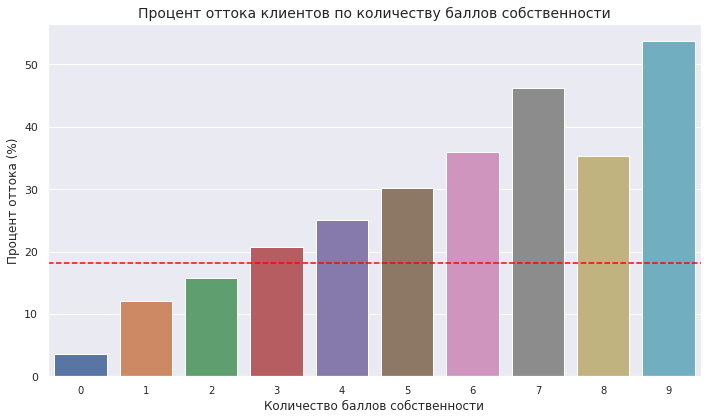

In [39]:
#строим график
plt.figure(figsize=(10, 6))
sns.barplot(data=customers_col_pivot, x='equity', y='churn_part_%')
plt.title('Процент оттока клиентов по количеству баллов собственности', fontsize=14)
plt.xlabel('Количество баллов собственности', fontsize=12)
plt.ylabel('Процент оттока (%)', fontsize=12)
plt.axhline(y=18.2, color='red', linestyle='--')
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show()

Менее лояльными являются клиенты, у которых от 3 до 9 баллов собственности включительно.

*products*:

In [40]:
#сначала составим таблицу по признаку
customers_col_pivot = customers_info.pivot_table(index='products', values='churn', aggfunc=['mean','sum','count']).reset_index()
customers_col_pivot.columns = ['products', 'churn_part_%', 'users_count_churn', 'users_count_total']
customers_col_pivot['churn_part_%'] = round(customers_col_pivot['churn_part_%']*100, 1)
customers_col_pivot = customers_col_pivot.sort_values(by='churn_part_%', ascending=False)
customers_col_pivot

,products,churn_part_%,users_count_churn,users_count_total
3,4,63.3,300,474
4,5,42.1,8,19
2,3,28.6,297,1039
1,2,19.1,979,5126
0,1,7.0,235,3341


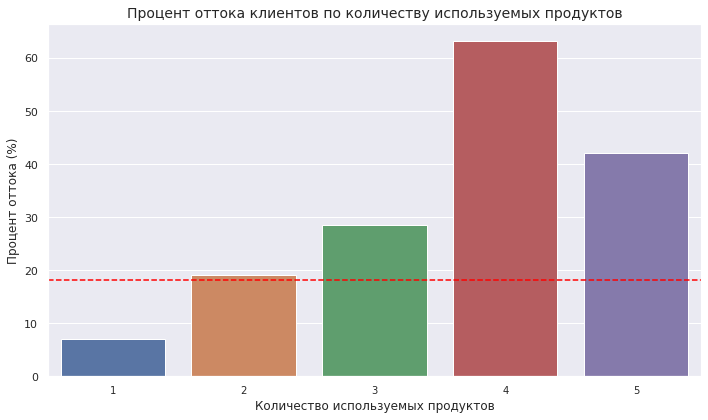

In [41]:
#строим график
plt.figure(figsize=(10, 6))
sns.barplot(data=customers_col_pivot, x='products', y='churn_part_%')
plt.title('Процент оттока клиентов по количеству используемых продуктов', fontsize=14)
plt.xlabel('Количество используемых продуктов', fontsize=12)
plt.ylabel('Процент оттока (%)', fontsize=12)
plt.axhline(y=18.2, color='red', linestyle='--')
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show()

Менее лояльными являются клиенты, у которых от 2 до 5 используемых продуктов банка включительно.

*credit_card*:

In [42]:
#сначала составим таблицу по признаку
customers_col_pivot = customers_info\
.pivot_table(index='credit_card', values='churn', aggfunc=['mean','sum','count']).reset_index()
customers_col_pivot.columns = ['credit_card', 'churn_part_%', 'users_count_churn', 'users_count_total']
customers_col_pivot['churn_part_%'] = round(customers_col_pivot['churn_part_%']*100, 1)
customers_col_pivot = customers_col_pivot.sort_values(by='churn_part_%', ascending=False).replace({0: 'Нет', 1: 'Есть'})
customers_col_pivot

,credit_card,churn_part_%,users_count_churn,users_count_total
0,Нет,25.5,816,3195
1,Есть,14.7,1003,6804


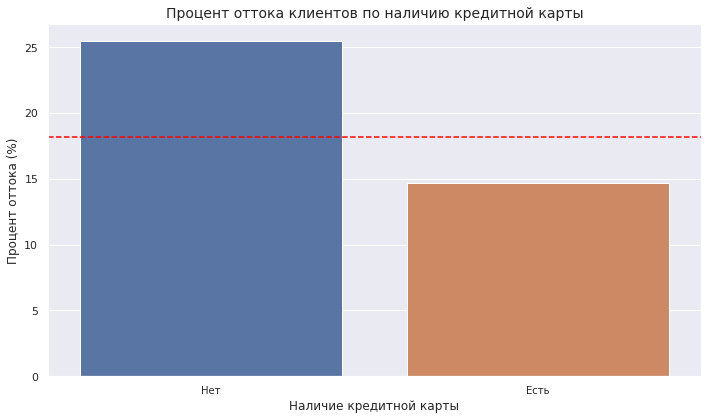

In [43]:
#строим график
plt.figure(figsize=(10, 6))
sns.barplot(data=customers_col_pivot, x='credit_card', y='churn_part_%')
plt.title('Процент оттока клиентов по наличию кредитной карты', fontsize=14)
plt.xlabel('Наличие кредитной карты', fontsize=12)
plt.ylabel('Процент оттока (%)', fontsize=12)
plt.axhline(y=18.2, color='red', linestyle='--')
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show()

Менее лояльными являются клиенты, у которых у которых нет кредитной карты банка (25.5% доля оттока).

*last_activity*:

In [44]:
#сначала составим таблицу по признаку
customers_col_pivot = customers_info\
.pivot_table(index='last_activity', values='churn', aggfunc=['mean','sum','count']).reset_index()
customers_col_pivot.columns = ['last_activity', 'churn_part_%', 'users_count_churn', 'users_count_total']
customers_col_pivot['churn_part_%'] = round(customers_col_pivot['churn_part_%']*100, 1)
customers_col_pivot = customers_col_pivot.sort_values(by='churn_part_%', ascending=False).replace({0: 'Нет', 1: 'Есть'})
customers_col_pivot

,last_activity,churn_part_%,users_count_churn,users_count_total
1,Есть,24.4,1278,5235
0,Нет,11.4,541,4764


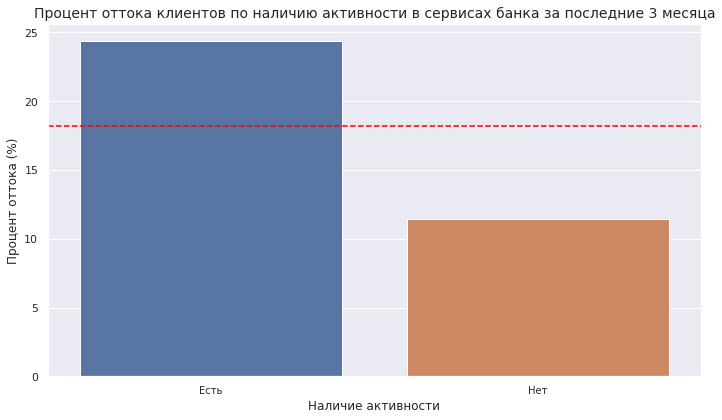

In [45]:
#строим график
plt.figure(figsize=(10, 6))
sns.barplot(data=customers_col_pivot, x='last_activity', y='churn_part_%')
plt.title('Процент оттока клиентов по наличию активности в сервисах банка за последние 3 месяца', fontsize=14)
plt.xlabel('Наличие активности', fontsize=12)
plt.ylabel('Процент оттока (%)', fontsize=12)
plt.axhline(y=18.2, color='red', linestyle='--')
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show()

Менее лояльными являются клиенты, у которых есть активность в сервисах банка за последние 3 месяца (24.4% доля оттока). Скорее всего это связано с тем, что клиенты без активности соответственно не имели возможности ответить на вопросы о желании прекратить сотрудничество с банком.

<a id='Корреляционный-анализ'></a>

Проведем корреляционный анализ признаков:

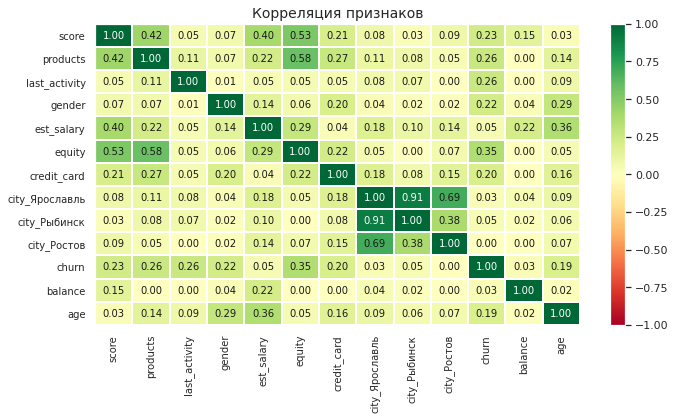

In [46]:
#считать корреляцию будем с помощью phi_k, т.к. это универсальный способ выявить взаимосвязь с разными типами значений,
#который, к тому же, учитывает не только прямую корреляцию

#формирование матрицы ФИк с указанием числовых столбцов 
phik_corr_matrix = (customers_info[customers_info.columns.difference(['user_id', 'missing_balance', 'missing_age', 'city'])]
                    .phik_matrix(interval_cols=['score', 'balance', 'est_salary', 'age']))

#визуализация с преобразованием матрицы в массив на входе, метки берем с оригинальной матрицы
plot_correlation_matrix(phik_corr_matrix.to_numpy(), 
                        x_labels=phik_corr_matrix.columns.to_list(), 
                        y_labels=phik_corr_matrix.index.to_list(),
                        title='Корреляция признаков',
                        figsize=(10, 6))

На текущем этапе нас интересует корреляция признаков с параметром оттока *churn*, выделим ее:

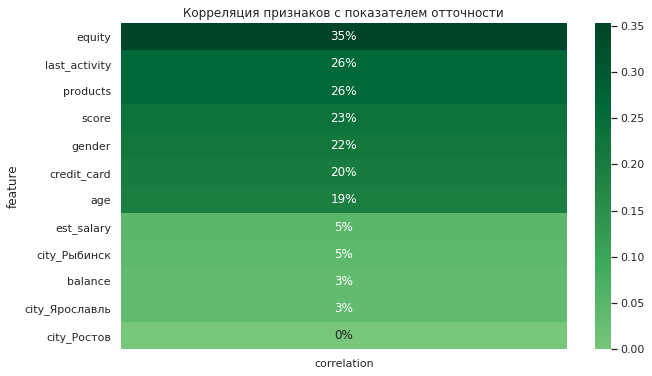

In [47]:
#сделаем столбец корреляции только по churn

#запишем отдельную переменную предыдущей матрицы только с churn
churn_correlation = phik_corr_matrix['churn'].sort_values(ascending=False).drop('churn').reset_index()
#определим столбцы
churn_correlation.columns = ['feature', 'correlation']

#визуализация с помощью seaborn, тк plot_correlation_matrix поддерживает только двумерный массив (все на все)
plt.figure(figsize=(10, 6))
sns.heatmap(churn_correlation.set_index('feature'), annot=True, fmt=".0%", cmap='YlGn', center=0)
plt.title('Корреляция признаков с показателем отточности')
plt.show()

Для оценки корреляции воспользуемся шкалой Чеддока, согласно которой:

0,1 – 0,3: слабая

0,3 – 0,5: умеренная

0,5 – 0,7: заметная

0,7 – 0,9: высокая

0,9 – 0,99: весьма высокая.

Таким образом, все признаки имеют слабую взаимосвязь с *churn*, параметром отточности, за исключением *equity*, количества баллов собственности - умеренная взаимосвязь.

(Необходимо иметь в виду, что используется только шкала Чеддока, сам коэффициент рассчитывается с помощью Phi_k) 

**Вывод:**

Проведен исследовательский анализ данных:

* Составлены портреты лояльного клиента и клиента, склонного к прекращению сотрудничества, выявленные характерные различия:

        * Баланс отточного клиента выше на 357679.5 (+46%);
        * Минимальная разница в примерном уровне дохода, у отточного клиента выше на 7137.5 (+6%);
        * Минимальная разница в возрасте, отточный клиент моложе на 1 год (-3%);
        * У отточного клиента больше баллов собственности на 2 (+100%);
        * У отточного клиента больше баллов скоринга на 18 (+2%);
        * Совпадает город: Ярославль;
        * Пол лояльного клиента: Ж, отточного клиента: М;
        * У обоих клиентов есть кредитная карта;
        * У отточного клиента есть активность за последние 3 месяца, у лояльного - нет.
        
* Рассчитаная доля отточных клиентов по банку: 18.2%;
        
* Проанализированы признаки и их отточные диапазоны/категории: 

        * score — диапазон: от 821 до 938, доля оттока по выделенному сегменту: 23.0 %;
        * city — Ростов (18.8% доля оттока) и Ярославль (19%);
        * gender — мужской пол (23.6% доля оттока);
        * age — диапазон: от 25 до 35 и от 50 до 60, доля оттока по выделенному сегменту: 24.3 %;
        * equity — от 3 до 9 баллов собственности (3 - 20.8%, 4 - 25.1%, 5 - 30.1%, 6 - 36%, 7 - 46.2%, 8 - 35.3%, 9 - 53.8%);
        * balance — диапазон: от 1140000, доля оттока по выделенному сегменту: 39.8 %;
        * products — от 2 до 5 используемых продуктов банка (2 - 19.1%, 3 - 28.6%, 4 - 63.3%, 5 - 42.1%);
        * credit_card — нет кредитной карты банка (25.5% доля оттока);
        * last_activity — есть активность в сервисах банка за последние 3 месяца (24.4% доля оттока);
        * est_salary — диапазон: от 93000 до 212000, доля оттока по выделенному сегменту: 20.2 %.

* Все признаки имеют слабую взаимосвязь (до 0.3 включительно) с churn, параметром отточности, за исключением equity, количества баллов собственности - умеренная взаимосвязь (0.35).

[Вернуться к содержанию](#Содержание)

<a id='Проверка-статистических-гипотез'></a>
## 4 Проверка статистических гипотез

Проверим гипотезы по текущему исследованию. 
<a id='Гипотеза-1'></a>

Сформулируем первую гипотезу:

H0: Доход клиентов у лояльных клиентов и склонных к прекращению сотрудничества равен;

H1: Доход клиентов значимо отличается у лояльных клиентов и склонных к прекращению сотрудничества.

In [48]:
#для проверки будем использовать критерий Манна-Уитни, тк исследуемый признак имеет правостороннее распределение(ассиметрия)
#и выбросы

#возьмем стандартную границу в 5%
alpha = .05
results = st.mannwhitneyu(customers_info[customers_info['churn']==1]['est_salary'],
                          customers_info[customers_info['churn']==0]['est_salary'])
print('p-значение: ', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

p-значение:  0.00021160652203623057
Отвергаем нулевую гипотезу: разница статистически значима


Таким образом, примерный доход лояльных и не лояльных клиентов, вероятно, различается в генеральной совокупности. 

Детальнее взглянем на значения соовтетствующих столбцов в нашей выборке: 

In [49]:
#выведем средний доход по группам
print('Средний доход по лояльным клиентам:', customers_info[customers_info['churn']==1]['est_salary'].mean())
print('Средний доход по не лояльным клиентам:', customers_info[customers_info['churn']==0]['est_salary'].mean())

Средний доход по лояльным клиентам: 148310.72820230896
Средний доход по не лояльным клиентам: 147783.20010757947


Видим, что значения слабо различаются, однако вероятность получить эту разницу случайно при условии, что эти значения в генеральной совокупности равны, составляет всего 0.02%, что говорит нам о неслучайности различия. 

Расширим проверку, добавив тест гипотезы с помощью t-критерия Стьюдента, и сравним результаты с уже выполненной проверкой u-критерием Манна-Уитни:

In [50]:
#ttest подходит только для нормально распределенных данных, в которых нет аномалий, так как сравниваются средние значения

#ранее мы посчитали распределение примерных зарплат ассиметричным (хвост вправо), проверим насколько это верно для групп
#используем тест Шапиро-Уилка на нормальность распределения
print("Вероятность нормального распределения зарплат отточной группы: p-value =", 
      st.shapiro(customers_info[customers_info['churn']==1]['est_salary']).pvalue)
print("Вероятность нормального распределения зарплат лояльной группы: p-value =", 
      st.shapiro(customers_info[customers_info['churn']==0]['est_salary']).pvalue)

#чаще всего выборки имеют схожую дисперсию, однако нам нужно выяснить равны ли дипсперсии групп для выбора конкретного теста
#с помощью t критерия: обычный t test или t test Уэлша (дисперсии не равны), для проверки будем использовать тест Левена
levene_test = st.levene(customers_info[customers_info['churn']==1]['est_salary'],
                        customers_info[customers_info['churn']==0]['est_salary'])
print("Вероятность равенства дисперсий двух групп: p-value =", levene_test.pvalue)

Вероятность нормального распределения зарплат отточной группы: p-value = 0.0
Вероятность нормального распределения зарплат лояльной группы: p-value = 0.0
Вероятность равенства дисперсий двух групп: p-value = 0.009384429599783289


У лояльной и отточной групп по примерному доходу нет нормального распределения, что делает дальнейшее тестирование с помощью t-критерия ненадежным, проверим его вывод:

In [51]:
#проведем проверку гипотезы с помощью t критерия тестом Уэлша (дисперсии не равны) 
results = st.ttest_ind(customers_info[customers_info['churn']==1]['est_salary'],
                      customers_info[customers_info['churn']==0]['est_salary'],
                      equal_var=False)
print('p-значение: ', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

p-значение:  0.8724727072323815
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


Как и предполагалось, тест с t-критерием показал другой результат, что демонстрирует важность учета распределения.
Тест с u-критерием, в свою очередь, сравнивает медианы, поэтому не так зависит от выбросов и нормальности распределения.

<a id='Гипотеза-2'></a>
Ранее мы выявили, что по нашим данным клиенты, которые были активны в течение последних 3 месяцев, более склонны к прекращению пользования сервисов банка, отток среди таких клиентов составляет 24.4% против 11.4% у тех клиентов, кто не был активен за последние 3 месяца. Мы связали это с опросами, на которых строится вывод о готовности к прекращению сотрудничества, неактивные пользователи не могут его пройти. Однако это исходя из природы сбора данных, в то время, как логически - неактивные пользователи чаще прекращают сотрудничество.

Выясним, похоже ли предположение об опросах на правду, и так же ли обстоят дела в случае с генеральной совокупностью.

Сформулируем вторую гипотезу:

H0: Доля отточных клиентов среди активных пользователей равна или меньше, чем аналогичная доля среди неактивных клиентов;

H1: Доля отточных клиентов среди активных пользователей больше, чем аналогичная доля среди неактивных клиентов.

In [52]:
#Тк мы имеем дело с долями и бинарными данными в столбце с активностью и оттоком(успех или нет),то будем использовать z-критерий
#Тест односторонний соответственно сформулированной гипотезе

#сохраним количество активнрых и неактивных отточнгых клиентов
active_churn_count = customers_info[(customers_info['last_activity']==1) & (customers_info['churn']==1)]['user_id'].count()
inactive_churn_count = customers_info[(customers_info['last_activity']==0) & (customers_info['churn']==1)]['user_id'].count()

#сохраним общее количество активных и неактивных клиентов
active_total = customers_info[customers_info['last_activity']==1]['user_id'].count()
inactive_total = customers_info[customers_info['last_activity']==0]['user_id'].count()

#обозначим количество попыток и успехов для теста
successes = [active_churn_count, inactive_churn_count]
totals = [active_total, inactive_total]

#проводим односторонний z test
stat, p_value = proportions_ztest(successes, totals, alternative='larger')

print('p-значение: ', p_value)
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: доля отточных клиентов среди активных выше, чем среди неактивных")
else:
    print("Не получилось отвергнуть нулевую гипотезу: доля отточных клиентов среди активных не выше, чем среди неактивных")

p-значение:  2.1436672145735158e-64
Отвергаем нулевую гипотезу: доля отточных клиентов среди активных выше, чем среди неактивных


С крайне большой вероятностью значение количества отточных клиентов среди активных пользователей выше, чем среди неактивных, в генеральной совокупности. Что оставляет в качестве объяснения только один вариант с опросами.

**Вывод:**

Проверены 2 гипотезы, согласно которым выявлено, что:

* Доход клиентов значимо отличается у лояльных клиентов и склонных к прекращению сотрудничества;

* Доля отточных клиентов среди активных пользователей больше, чем аналогичная доля среди неактивных клиентов.

[Вернуться к содержанию](#Содержание)

<a id='Сегментация-пользователей'></a>
## 5 Сегментация пользователей

<a id='Разделение-клиентов'></a>
Проведем сегментацию клиентов банка на основе исследованных признаков и их выявленных диапазонов "оттока":

In [53]:
#выделим 1 сегмент по активности, наличию кредитной карты и количеству используемых продуктов
segment_1 = customers_info[(customers_info['last_activity'] == 1) & 
                           (customers_info['credit_card'] == 0) &
                           (customers_info['products'] >= 2) &
                           (customers_info['products'] <= 5)]

#2 сегмент: по балансу, баллам собственности, примерной зп и баллам скоринга
segment_2 = customers_info[(customers_info['balance'] > 1140000) &
                           (customers_info['equity'] >= 3) &
                           (customers_info['equity'] <= 9) & 
                           (customers_info['est_salary'] >= 93000) & 
                           (customers_info['est_salary'] <= 212000) &
                           (customers_info['score'] >= 821) &
                           (customers_info['score'] <= 938)]

#3 сегмент: по городу, полу и возрасту
segment_3 = customers_info[((customers_info['city'] == 'Ростов') | (customers_info['city'] == 'Ярославль')) &
                           (customers_info['gender'] == 1) & 
                           (customers_info['age'] > 50) & (customers_info['age'] < 60)]

#выведем основную инфомрацию по сегментам
print("Размер сегмента 1:", segment_1['user_id'].count())
print("Доля оттока в сегменте 1 (%):", segment_1['churn'].mean() * 100)
print('-'*48)
print("Размер сегмента 2:", segment_2['user_id'].count())
print("Доля оттока в сегменте 2 (%):", segment_2['churn'].mean() * 100)
print('-'*48)
print("Размер сегмента 3:", segment_3['user_id'].count())
print("Доля оттока в сегменте 3 (%):", segment_3['churn'].mean() * 100)

Размер сегмента 1: 1493
Доля оттока в сегменте 1 (%): 40.25452109845948
------------------------------------------------
Размер сегмента 2: 606
Доля оттока в сегменте 2 (%): 53.46534653465347
------------------------------------------------
Размер сегмента 3: 441
Доля оттока в сегменте 3 (%): 36.961451247165535


У нас есть 3 сегмента клиентов, каждый из которых использует несколько ключевых отточных признаков. 

Сформируем портрет типипчного клиента по каждому сегменту:

In [54]:
#у нас 3 сегмента, запишем функцию с созданием таблицы-портрета, практически аналогичной из исследования данных
def create_segment_portrait(segment):
    """
    Создает таблицу с портретом типичного клиента по сегменту.

    Принимает:
    - segment (DataFrame): Данные выделенного сегмента.

    Возвращает:
    - DataFrame: Таблица с характеристиками сегмента.
    """
    continuous_cols = ['balance', 'est_salary']
    discrete_cols = ['age', 'equity', 'products', 'score']
    categorical_cols = ['city', 'gender', 'credit_card', 'last_activity']
    
    results = []
    
    # Обработка столбцов с непрерывными значениями
    for col in continuous_cols:
        mean_value = segment[col].mean().round(1)
        median_value = segment[col].median().round(1)
        results.append([col, 'mean', mean_value])
        results.append([col, 'median', median_value])
    
    # Обработка столбцов с дискретными значениями
    for col in discrete_cols:
        median_value = segment[col].median().round(1)
        results.append([col, 'median', median_value])
    
    # Обработка столбцов с категориальными значениями
    for col in categorical_cols:
        mode_value = segment[col].mode()[0]
        results.append([col, 'mode', mode_value])
    
    # Создание таблицы
    segment_portrait = pd.DataFrame(
        results, 
        columns=['feature', 'central_tendency', 'value']
    )
    
    # Замена числовых категорий на текстовые
    segment_portrait.loc[segment_portrait['feature'] == 'gender', 'value'] = \
        segment_portrait.loc[segment_portrait['feature'] == 'gender', 'value'].replace({0: 'Ж', 1: 'М'})
    
    segment_portrait.loc[segment_portrait['feature'].isin(['credit_card', 'last_activity']), 'value'] = \
        segment_portrait.loc[segment_portrait['feature'].isin(['credit_card', 'last_activity']), 'value']\
        .replace({0: 'Нет', 1: 'Есть'})
    
    return segment_portrait

Сформируем портрет клиента по 1 сегменту, который основан на отточных диапазонах признаков, относящихся к активности и пользованию продуктов банка:

In [55]:
create_segment_portrait(segment_1)

,feature,central_tendency,value
0,balance,mean,1025770.1
1,balance,median,675832.8
2,est_salary,mean,134761.5
3,est_salary,median,111281.0
4,age,median,42.0
5,equity,median,4.0
6,products,median,2.0
7,score,median,852.0
8,city,mode,Ярославль
9,gender,mode,Ж


Судя по портрету, клиенты первого сегмента - активные пользователи с высоким уровнем дохода и финансовым остатком. Они финансово стабильны и активно взаимодействуют с банком, что делает их важной группой для дальнейшего удержания и повышения лояльности.

Сформируем портрет клиента по 2 сегменту, который основан на отточных диапазонах признаков, относящихся к количественной оценке финансовой стабильности клиента:

In [56]:
create_segment_portrait(segment_2)

,feature,central_tendency,value
0,balance,mean,1896033.7
1,balance,median,1456263.3
2,est_salary,mean,149433.8
3,est_salary,median,147495.4
4,age,median,42.0
5,equity,median,4.0
6,products,median,2.0
7,score,median,897.0
8,city,mode,Ярославль
9,gender,mode,М


Клиенты второго сегмента демонстрируют высокую финансовую стабильность и имеют значительные активы. Они активно используют банковские услуги, хотя их взаимодействие, скорее всего, сосредоточено на базовых продуктах.

Сформируем портрет клиента по 3 сегменту, который основан на личных биографичных данных:

In [57]:
create_segment_portrait(segment_3)

,feature,central_tendency,value
0,balance,mean,1305109.9
1,balance,median,827794.3
2,est_salary,mean,151439.6
3,est_salary,median,113790.6
4,age,median,55.0
5,equity,median,3.0
6,products,median,2.0
7,score,median,859.0
8,city,mode,Ярославль
9,gender,mode,М


Клиенты третьего сегмента - это преимущественно мужчины старшего возраста с высоким доходом, но менее активные в использовании банковских сервисов.

<a id='Приоритизация-сегментов'></a>
Приоритизируем сегменты: 

1. Сегмент 2

   * Доля оттока: 53.47%
   * Размер сегмента: 606 клиентов

2. Сегмент 1

   * Доля оттока: 40.25%
   * Размер сегмента: 1493 клиента

3. Сегмент 3

   * Доля оттока: 36.96%
   * Размер сегмента: 441 клиента

Критерии приоритизации:
1. Доля оттока (%): основной показатель, так как сегменты с большей долей оттока требуют срочного внимания для минимизации потерь.
2. Размер сегмента: второстепенный критерий, так как он влияет на абсолютное число клиентов, которых можно удержать. Однако в условиях ограниченности ресурсов, первоочередное внимание должно быть направлено на сегменты с самым высоким процентом оттока.

**Вывод:**

Проведена сегментация клиентов и последующая приоритизация:

1. Сегмент 2 - основан на отточных диапазонах признаков, относящихся к количественной оценке финансовой стабильности клиента, клиенты - демонстрируют высокую финансовую стабильность и имеют значительные активы

* Доля оттока: 53.47%
* Размер сегмента: 606 клиентов

2. Сегмент 1 - основан на отточных диапазонах признаков, относящихся к активности и пользованию продуктов банка, клиенты - активные пользователи с высоким уровнем дохода и финансовым остатком

* Доля оттока: 40.25%
* Размер сегмента: 1493 клиента

3. Сегмент 3 - основан на личных биографичных данных, клиенты - преимущественно мужчины старшего возраста с высоким доходом, но менее активные в использовании банковских сервисов

* Доля оттока: 36.96%
* Размер сегмента: 441 клиента

[Вернуться к содержанию](#Содержание)

<a id='Общий-вывод'></a>
## 6 Общий вывод

**Исследование данных**:

* Составлены портреты лояльного клиента и клиента, склонного к прекращению сотрудничества, выявленные характерные различия:

  * Баланс отточного клиента выше на 357679.5 (+46%);
  * Минимальная разница в примерном уровне дохода, у отточного клиента выше на 7137.5 (+6%);
  * Минимальная разница в возрасте, отточный клиент моложе на 1 год (-3%);
  * У отточного клиента больше баллов собственности на 2 (+100%);
  * У отточного клиента больше баллов скоринга на 18 (+2%);
  * Совпадает город: Ярославль;
  * Пол лояльного клиента: Ж, отточного клиента: М;
  * У обоих клиентов есть кредитная карта;
  * У отточного клиента есть активность за последние 3 месяца, у лояльного - нет.
  
* Рассчитаная доля отточных клиентов по банку: 18.2%;

* Проанализированы признаки и их отточные диапазоны/категории:

  * score — диапазон: от 821 до 938, доля оттока по выделенному сегменту: 23.0 %;
  * city — Ростов (18.8% доля оттока) и Ярославль (19%);
  * gender — мужской пол (23.6% доля оттока);
  * age — диапазон: от 25 до 35 и от 50 до 60, доля оттока по выделенному сегменту: 24.3 %;
  * equity — от 3 до 9 баллов собственности (3 - 20.8%, 4 - 25.1%, 5 - 30.1%, 6 - 36%, 7 - 46.2%, 8 - 35.3%, 9 - 53.8%);
  * balance — диапазон: от 1140000, доля оттока по выделенному сегменту: 39.8 %;
  * products — от 2 до 5 используемых продуктов банка (2 - 19.1%, 3 - 28.6%, 4 - 63.3%, 5 - 42.1%);
  * credit_card — нет кредитной карты банка (25.5% доля оттока);
  * last_activity — есть активность в сервисах банка за последние 3 месяца (24.4% доля оттока);
  * est_salary — диапазон: от 93000 до 212000, доля оттока по выделенному сегменту: 20.2 %.
  
* Все признаки имеют слабую взаимосвязь (до 0.3 включительно) с churn, параметром отточности, за исключением equity, количества баллов собственности - умеренная взаимосвязь (0.35).

**Проверка гипотез**:

Вероятные выводы о генеральной совокупности после проверки 2 гипотез:

* Доход клиентов значимо отличается у лояльных клиентов и склонных к прекращению сотрудничества;

* Доля отточных клиентов среди активных пользователей больше, чем аналогичная доля среди неактивных клиентов.

**Сегментация пользователей**:

Проведена сегментация клиентов и последующая приоритизация:

1. Сегмент 2 - основан на отточных диапазонах признаков, относящихся к количественной оценке финансовой стабильности клиента, клиенты - демонстрируют высокую финансовую стабильность и имеют значительные активы

* Доля оттока: 53.47%
* Размер сегмента: 606 клиентов

2. Сегмент 1 - основан на отточных диапазонах признаков, относящихся к активности и пользованию продуктов банка, клиенты - активные пользователи с высоким уровнем дохода и финансовым остатком

* Доля оттока: 40.25%
* Размер сегмента: 1493 клиента

3. Сегмент 3 - основан на личных биографичных данных, клиенты - преимущественно мужчины старшего возраста с высоким доходом, но менее активные в использовании банковских сервисов

* Доля оттока: 36.96%
* Размер сегмента: 441 клиента

**Рекомендация**:

Предложения для кампании по удержанию в порядке приоритизации.

1. *Сегмент 2*:

Сегмент характеризуется высоким балансом, хорошей финансовой стабильностью, но клиенты активно покидают банк. Мужчины преобладают в этом сегменте, и у большинства отсутствует кредитная карта. Это может говорить о недостатке привлекательных предложений или ненужности существующих продуктов.

* Эксклюзивная карта для инвестиций:

    - Предложить кредитную карту с бесплатным обслуживанием при условии совершения операций через партнерские инвестиционные платформы;
    - Возможность получить повышенный кешбэк на инвестиционные операции.

* Инвестиционные вебинары и аналитика:

    - Организовать серию вебинаров по управлению капиталом для клиентов этого сегмента;
    - Бесплатно предоставлять ежемесячные финансовые обзоры (анализ рынков, прогнозы).

2. *Сегмент 1*:

Клиенты активно взаимодействуют с банковскими сервисами, но, возможно, их ожидания не удовлетворяются. Эти клиенты пользуются несколькими продуктами банка, но лояльность снижается. У них нет кредитной карты, что также может быть возможным фактором неудовлетворенности. В целом сегмент во многом похож на 2ой, но с меньшими финансовыми возможностями.

* Кешбэк за активное использование продуктов:

    - Внедрить временную программу лояльности: клиенты получают кешбэк 5% на определенные категории покупок при использовании продуктов банка (например, интернет-банкинга или мобильного приложения);
    - Условие: кешбэк начисляется при выполнении определенного числа транзакций в течение месяца.
    
* Промо-кредитные карты:

    - Предложить бесплатное оформление кредитной карты с повышенным кешбэком для первых 3 месяцев (например, 10% на категории покупок);
    - Упрощенная процедура оформления через мобильное приложение.

3. *Сегмент 3*:

Эти клиенты старше, имеют средний баланс, но довольно высокий уровень дохода. Большинство из них мужчины, не активные в использовании сервисов банка. У них есть кредитные карты, что может быть связано с традиционным подходом к финансам.

* Пакет услуг, предоставляемый комплексно на всю семью:

    - Разработать продукт для объединения счетов в рамках семьи;
    - Бесплатное обслуживание карт для детей или супругов.

* Цифровая вовлеченность:

    - Обучающие курсы и инструкции по работе с мобильным приложением;
    - Запуск акции для новичков: первые 3 месяца активного использования мобильного банка — 500 рублей на счет.


<a id='Презентация'></a>
## 7 Презентация

Ссылка на презентацию: https://drive.google.com/file/d/1KqXP2UvgZ-EGG49VkD1uDw7ulAJvUVQe/view?usp=sharing

Резерв: https://github.com/netrunner55746/Yandex-Practicum.Data-Analyst/blob/main/artifacts/bank_clients_churn_analysis_vs.pdf